In [1]:
import os
import glob
from shutil import copyfile
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

## Load images
- convert images to greyscale
- resize to 64 x 64
- load into numpy array and reshape to a 2D array

In [2]:
# read data
filelist = glob.glob('../../../data/zalando_models/kleider_small/*.jpg')
print('num images: ', len(filelist))

num images:  27324


In [3]:
def resize_image(img, size):
    return img.resize(size, Image.ANTIALIAS)

In [4]:
img_size = [64, 64]

In [8]:
sampled_filelist = np.random.choice(filelist, 2000)
X = np.array([np.array(ImageOps.grayscale(resize_image(Image.open(fname), size=img_size))) for fname in sampled_filelist])
print('X shape', X.shape)
X = X.reshape([X.shape[0], X.shape[1] * X.shape[2]])
print(X.shape)

X shape (2000, 64, 64)
(2000, 4096)


## Cluster
Find 3 clusters - usually whole model image, zoomed model image and detail images

In [9]:
m_km = KMeans(n_clusters=3)
m_km.fit(X)
m_clusters = m_km.labels_.tolist()

In [10]:
df = pd.DataFrame(list(zip(m_clusters, filelist)), columns=['cluster', 'path'])
df.groupby('cluster').count()

,path
cluster,
0,413
1,1085
2,502


#### Plot cluster centers

(4096,)


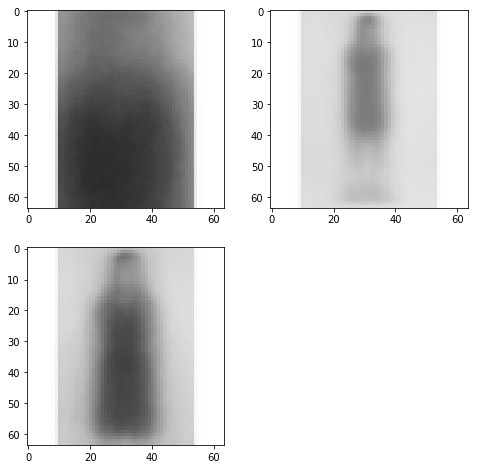

In [11]:
fig=plt.figure(figsize=(8, 8))
centers = np.array(m_km.cluster_centers_)
print(centers[0].shape)
for idx, center in enumerate(centers):
    fig.add_subplot(2, 2, idx+1)
    center = center.reshape(img_size)
    img = Image.fromarray(center)
    plt.imshow(img)
plt.show()

#### Plot random sample of images that belong to each cluster

Cluster:  0
Images:  413


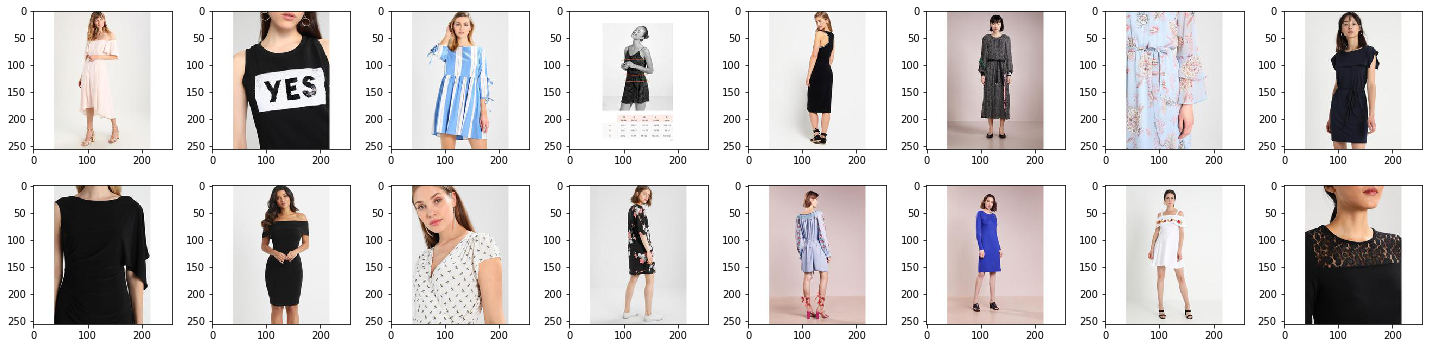

Cluster:  1
Images:  1085


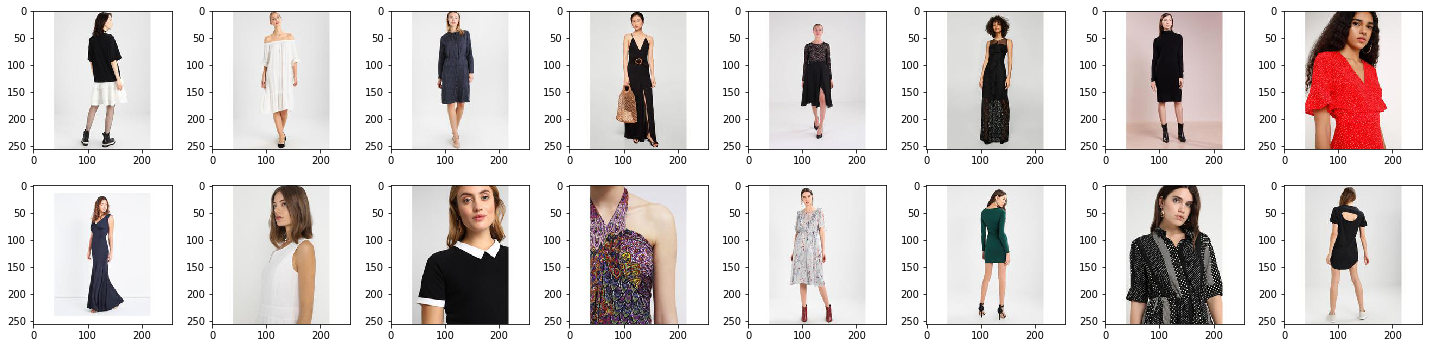

Cluster:  2
Images:  502


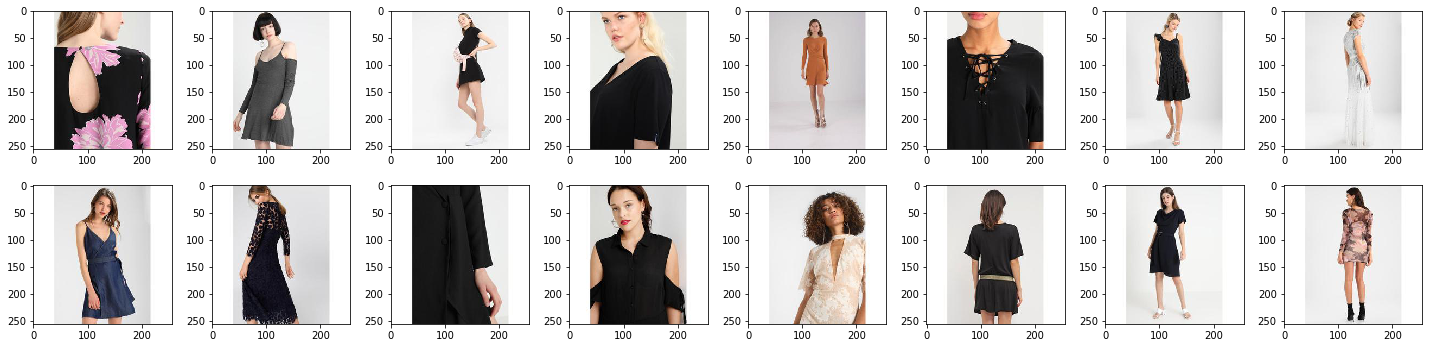

In [12]:
cluster_imgs = df.groupby('cluster').agg({'path': 'unique'})
for cluster in cluster_imgs.index:
    print('Cluster: ', cluster)
    print('=' * 100)
    imgs = cluster_imgs.loc[cluster, 'path'].tolist()
    print('Images: ', len(imgs))
    imgs = random.sample(imgs, 16)
    img_count = len(imgs)
    
    fig=plt.figure(figsize=(20, 5))
    for idx, img_path in enumerate(imgs):
        fig.add_subplot(2, 8, idx+1)
        img = Image.open(img_path)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()
    

## Save images
for each product, get all of its model images and identify the one closest to the best cluster center -> whole model image

In [14]:
# best cluster center
cluster_center = np.array(m_km.cluster_centers_)[1]

# path to filtered images
filtered_folder = '../../../data/zalando_models/kleider_one/'

In [15]:
orig_images = glob.glob('../../../data/zalando/kleider/*.jpg')
for idx, orig_img in enumerate(orig_images):
    if idx % 100 == 0:
        print(idx)
    
    img_name = os.path.basename(orig_img)
    
    try:
        model_imgs = [model_img for model_img in filelist 
                      if os.path.basename(model_img).split('@')[0] == img_name.split('.')[0]]

        # load all model images in greyscale and resized
        X = np.array([np.array(ImageOps.grayscale(resize_image(Image.open(fname), size=img_size))) for fname in model_imgs])
        X = X.reshape([X.shape[0], X.shape[1] * X.shape[2]])

        # calculate distance matrix
        distances = pairwise_distances(X, cluster_center.reshape(1, -1))
        best_img = model_imgs[distances.argmin()]
        dst_img = os.path.join(filtered_folder, img_name)
        copyfile(best_img, dst_img)
    except:
        print('Problem with image', img_name)

0
100
200
Problem with image S5521C02L-Q11.jpg
Problem with image PE321C05U-K11.jpg
300
400
500
Problem with image SAD21C02C-Q11.jpg
600
Problem with image AR321C040-K11.jpg
700
800
Problem with image SAD21C032-Q11.jpg
900
1000
1100
1200
Problem with image SAD21C03E-A11.jpg
1300
Problem with image SAD21C02M-G11.jpg
1400
Problem with image PUC21C03I-Q11.jpg
Problem with image SAD21C030-Q11.jpg
1500
1600
Problem with image SAD21C02V-K11.jpg
Problem with image AR321C03U-K11.jpg
1700
1800
1900
Problem with image SAD21C039-Q11.jpg
Problem with image 2GU21C06S-Q11.jpg
2000
Problem with image GU121C0C0-Q11.jpg
Problem with image DE121C0FN-K11.jpg
2100
2200
Problem with image 2GU21C077-Q11.jpg
2300
2400
2500
2600
Problem with image SAD21C031-Q11.jpg
2700
Problem with image GU121C0DJ-Q11.jpg
2800
Problem with image MAL21C03I-Q11.jpg
2900
3000
3100
Problem with image GU121C0D9-G11.jpg
3200
Problem with image SAD21C034-Q11.jpg
Problem with image GU121C0DL-K11.jpg
3300
3400
Problem with image 2GU2